In [1]:
# Name: Shashank Nelamangala Sridhara
# USC ID Number: 2082227554
# USC Email: nelamang@usc.edu
# Submission Date: 11/03/2020

!pip install torchvision
!pip install efficientnet_pytorch
from google.colab import drive
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
drive.mount('/content/drive')


  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=4c81f2e2a9c1e4bb18c10bd1b5a665ade7e2b6d5bd8d4fae3ab8dc8257e57c11
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch
Mounted at /content/drive


In [2]:
#Preprocess the data
trainSet = datasets.CIFAR10("drive/My Drive/CSCI677-Homeworks", train = True, download = True, 
            transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.RandomErasing()]))
testSet = datasets.CIFAR10("drive/My Drive/CSCI677-Homeworks",  train = False, download = True, 
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

validation_split = 0.2
shuffle_dataset = True
random_seed= 42

dataset_size = len(trainSet)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))


if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainImages = torch.utils.data.DataLoader(trainSet, batch_size = 64, sampler=train_sampler, num_workers=2)
validationImages = torch.utils.data.DataLoader(trainSet, batch_size=64,sampler=valid_sampler,num_workers=2)
testImages = torch.utils.data.DataLoader(testSet, batch_size = 1000, shuffle = True,num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainSet.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [4]:
#To check whether the data is balanced
count1 = 0
obj_dict1 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
for imgs in trainImages:
  Images, labels = imgs
  for l in labels:
    obj_dict1[int(l)] += 1
    count1 +=1

count2 = 0
obj_dict2 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
for imgs in validationImages:
  Images, labels = imgs
  for l in labels:
    obj_dict2[int(l)] += 1
    count2 +=1


count3 = 0
obj_dict3 = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
for imgs in testImages:
  Images, labels = imgs
  for l in labels:
    obj_dict3[int(l)] += 1
    count3 +=1

print ("Training Set: ",obj_dict1)
print ("Validation Set: ",obj_dict2)
print ("Test Set: ",obj_dict3)


Training Set:  {0: 4027, 1: 4021, 2: 3970, 3: 3977, 4: 4067, 5: 3985, 6: 4004, 7: 4006, 8: 3983, 9: 3960}
Validation Set:  {0: 973, 1: 979, 2: 1030, 3: 1023, 4: 933, 5: 1015, 6: 996, 7: 994, 8: 1017, 9: 1040}
Test Set:  {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [4]:
#Baseline Model : LeNet-5 architecture
import torch.nn as nn
import torch.nn.functional as Func
#from efficientnet_pytorch import EfficientNet

class Net(nn.Module):
  def __init__(self, model_name='efficientnet-b0'):
    super(Net, self).__init__()
    #model = EfficientNet.from_pretrained(model_name)
    #self.model = model

    #Defining 2 convolution layers
    self.convotionLayer1 = nn.Conv2d(3, 6, 5)
    self.convotionLayer2 = nn.Conv2d(6, 16, 5)
    #Defining Fully connected Layers (y = Wx + b)
    self.fullyConnected1 = nn.Linear(16 * 5 * 5, 120)
    self.fullyConnected2 = nn.Linear(120, 84)
    self.fullyConnected3 = nn.Linear(84, 10)

  def forward(self, imageFeatures):
    #imageFeatures = self.model.extract_features(imageFeatures)
    imageFeatures = Func.max_pool2d(Func.relu(self.convotionLayer1(imageFeatures)), (2, 2))
    # If the size is a square you can only specify a single number
    imageFeatures = Func.max_pool2d(Func.relu(self.convotionLayer2(imageFeatures)), (2,2))
    imageFeatures = imageFeatures.view(-1, 16*5*5)
    imageFeatures = Func.relu(self.fullyConnected1(imageFeatures))
    imageFeatures = Func.relu(self.fullyConnected2(imageFeatures))
    imageFeatures = self.fullyConnected3(imageFeatures)
    return imageFeatures


cnn = Net()
print(cnn)
params = list(cnn.parameters())
print(len(params))
print(params[0].size())

input = torch.randn(3,3,32,32)
output = cnn(input)
print(output)
labels = torch.randn(10)
labels = labels.view(1, -1) 


numberOfParams= sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(numberOfParams)





Net(
  (convotionLayer1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (convotionLayer2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fullyConnected1): Linear(in_features=400, out_features=120, bias=True)
  (fullyConnected2): Linear(in_features=120, out_features=84, bias=True)
  (fullyConnected3): Linear(in_features=84, out_features=10, bias=True)
)
10
torch.Size([6, 3, 5, 5])
tensor([[-0.1063, -0.0613,  0.0143,  0.0080,  0.0796, -0.1026, -0.0027, -0.0712,
         -0.0034, -0.0750],
        [-0.0856, -0.0549,  0.0013,  0.0023,  0.0953, -0.0928,  0.0138, -0.0619,
          0.0230, -0.0588],
        [-0.0961, -0.0679, -0.0019, -0.0101,  0.1061, -0.1135, -0.0025, -0.0830,
          0.0300, -0.0425]], grad_fn=<AddmmBackward>)
62006


In [8]:
#Model 4: LeNet-5 architecture with dropout, batch normalization 
import torch.nn as nn
import torch.nn.functional as Func
#from efficientnet_pytorch import EfficientNet

class Net(nn.Module):
  def __init__(self, model_name='efficientnet-b0'):
    super(Net, self).__init__()
    #model = EfficientNet.from_pretrained(model_name)
    #self.model = model

    #Defining 2 convolution layers
    self.convotionLayer1 = nn.Conv2d(3, 32, 3)
    self.drop1 = nn.Dropout2d(0.3)
    self.conv1_bn = nn.BatchNorm2d(32)

    self.convotionLayer2 = nn.Conv2d(32, 64, 3)
    self.drop2 = nn.Dropout2d(0.3)
    self.conv2_bn = nn.BatchNorm2d(64)

    self.convotionLayer3 = nn.Conv2d(64, 128, 3)
    self.drop3 = nn.Dropout2d(0.3)
    self.conv3_bn = nn.BatchNorm2d(128)

    #Defining Fully connected Layers (y = Wx + b)
    self.fullyConnected1 = nn.Linear(128 * 3 * 3, 256)
    self.fc1_bn = nn.BatchNorm1d(256)

    self.fullyConnected2 = nn.Linear(256, 128)
    self.fc2_bn = nn.BatchNorm1d(128)

    self.fullyConnected3 = nn.Linear(128, 10)

  def forward(self, imageFeatures):
    imageFeatures = Func.max_pool2d(Func.relu(self.conv1_bn(self.drop1(self.convotionLayer1(imageFeatures)))), (2, 2))
    print(imageFeatures.shape)
    # If the size is a square you can only specify a single number
    imageFeatures = Func.max_pool2d(Func.relu(self.conv2_bn(self.drop2(self.convotionLayer2(imageFeatures)))), (2,2))
    print(imageFeatures.shape)
    imageFeatures = imageFeatures.view(-1, 128*3*3)
    print(imageFeatures.shape)
    imageFeatures = Func.relu(self.fc1_bn(self.fullyConnected1(imageFeatures)))
    print(imageFeatures.shape)
    imageFeatures = Func.relu(self.fc2_bn(self.fullyConnected2(imageFeatures)))
    print(imageFeatures.shape)
    imageFeatures = self.fullyConnected3(imageFeatures)
    print(imageFeatures.shape)
    return imageFeatures


cnn = Net()
print(cnn)
params = list(cnn.parameters())
print(len(params))
print(params[0].size())

input = torch.randn(3,3,32,32)
output = cnn(input)
print(output)
labels = torch.randn(10)
labels = labels.view(1, -1) 

numberOfParams= sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(numberOfParams)




Net(
  (convotionLayer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout2d(p=0.3, inplace=False)
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convotionLayer2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout2d(p=0.3, inplace=False)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convotionLayer3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (drop3): Dropout2d(p=0.3, inplace=False)
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fullyConnected1): Linear(in_features=1152, out_features=256, bias=True)
  (fc1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fullyConnected2): Linear(in_features=256, out_features=128, bias=True)
  (fc2_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fullyConnected3): Linear(in_feat

In [4]:
#Model 5: Weight decay, Data augmentation, Data Processsing
#Build a Neural Network
import torch.nn as nn
import torch.nn.functional as Func
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        #model = EfficientNet.from_pretrained(model_name)
        #self.model = model

        #Defining 2 convolution layers
        self.convotionLayer1 = nn.Conv2d(3, 32, 3)
        self.drop1 = nn.Dropout2d(0.2)
        self.conv1_bn = nn.BatchNorm2d(32)

        self.convotionLayer2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)

        self.convotionLayer3 = nn.Conv2d(32, 64, 3)
        self.drop3 = nn.Dropout2d(0.3)
        self.conv3_bn = nn.BatchNorm2d(64)

        self.convotionLayer4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(64)

        self.convotionLayer5 = nn.Conv2d(64, 128, 3)
        self.drop5 = nn.Dropout2d(0.4)
        self.conv5_bn = nn.BatchNorm2d(128)

        #Defining Fully connected Layers (y = Wx + b)
        self.fullyConnected1 = nn.Linear(128*2*2, 256)
        self.fc1_bn = nn.BatchNorm1d(256)

        self.fullyConnected2 = nn.Linear(256, 64)
        self.fc2_bn = nn.BatchNorm1d(64)

        self.fullyConnected3 = nn.Linear(64, 10)

    def forward(self, imageFeatures):
        elu = nn.ELU()

        conv1 = elu(self.conv1_bn(self.drop1(self.convotionLayer1(imageFeatures))))
        imageFeatures = Func.max_pool2d(conv1, (2, 2))
        #print(imageFeatures.shape)
        # If the size is a square you can only specify a single number

        imageFeatures = elu(self.conv2_bn(self.convotionLayer2(imageFeatures)))
        #print(imageFeatures.shape)

        conv3 = elu(self.conv3_bn(self.drop3(self.convotionLayer3(imageFeatures))))
        imageFeatures = Func.max_pool2d(conv3, (2, 2))
        #print(imageFeatures.shape)

        imageFeatures = elu(self.conv4_bn(self.convotionLayer4(imageFeatures)))
        #print(imageFeatures.shape)


        conv5 = elu(self.conv5_bn(self.drop5(self.convotionLayer5(imageFeatures))))
        imageFeatures = Func.max_pool2d(conv5, (2, 2))

        #print(imageFeatures.shape)

        imageFeatures = imageFeatures.view(-1, 128*2*2)
        imageFeatures = elu(self.fc1_bn(self.fullyConnected1(imageFeatures)))
        imageFeatures = elu(self.fc2_bn(self.fullyConnected2(imageFeatures)))
        imageFeatures = self.fullyConnected3(imageFeatures)
        return imageFeatures

    def num_flat_features(self, imageFeatures):
      length = imageFeatures.size()[1:]  # all dimensions except the batch dimension
      featureDim = 1
      for k in length:
        featureDim *= k
      return featureDim

cnn = Net()
print(cnn)
params = list(cnn.parameters())
print(len(params))
#print(params[0].size())

input = torch.randn(3,3,32,32)
output = cnn(input)
print(output)
labels = torch.randn(10)
labels = labels.view(1, -1) 

numberOfParams= sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(numberOfParams)

Net(
  (convotionLayer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout2d(p=0.2, inplace=False)
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convotionLayer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convotionLayer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop3): Dropout2d(p=0.3, inplace=False)
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convotionLayer4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convotionLayer5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (drop5): Dropout2d(p=0.4, inplace=False)
  (conv5_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully

In [7]:
import torch.optim as optim

def evalAccuracy():
  #Overall train and test accuracy
  correctClassification_train = 0
  totalImages_train = 0

  correctClassification_test = 0
  totalImages_test = 0

  with torch.no_grad():
    for data in trainImages:
      img, label = data
      output = cnn(img)
      for i,k in enumerate(output):
        if torch.argmax(k) == label[i]:
          correctClassification_train +=1
        totalImages_train +=1

  with torch.no_grad():
    for data in validationImages:
      img, label = data
      output = cnn(img)
      for i,k in enumerate(output):
        if torch.argmax(k) == label[i]:
          correctClassification_test +=1
        totalImages_test +=1

  trainAccuracy = correctClassification_train/totalImages_train      
  testAccuracy = correctClassification_test/totalImages_test
  return trainAccuracy, testAccuracy

def training(learningRate, momentum, epochs, criterion, optimizer):
  trainingAccuracyList = []
  testingAccuracyList = []

  running_loss = 0
  for epoch in range(epochs):
    for i, trainData in enumerate(trainImages, 0):
      imgs, labels = trainData

      #set the gradient to zero
      optimizer.zero_grad()
      outputs = cnn(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    print(epoch, loss)

    trainAccuracy, testAccuracy = evalAccuracy()
    trainingAccuracyList.append(trainAccuracy)
    testingAccuracyList.append(testAccuracy)

  return trainingAccuracyList, testingAccuracyList

#define training parameters
learningRate = 0.001
momentum = 0.9
epochs = 80
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)


#Call training function
trainingAccuracyList, testingAccuracyList = training(learningRate, momentum, epochs, criterion, optimizer)
print("Train Accuracy for Each Epoch: ",trainingAccuracyList)
print("Test Accuracy for Each Epoch: ", testingAccuracyList)



0 tensor(1.6023, grad_fn=<NllLossBackward>)
1 tensor(1.4861, grad_fn=<NllLossBackward>)
2 tensor(1.7494, grad_fn=<NllLossBackward>)
3 tensor(1.4682, grad_fn=<NllLossBackward>)
4 tensor(1.5358, grad_fn=<NllLossBackward>)
5 tensor(1.4694, grad_fn=<NllLossBackward>)
6 tensor(1.1941, grad_fn=<NllLossBackward>)
7 tensor(1.2749, grad_fn=<NllLossBackward>)
8 tensor(1.1660, grad_fn=<NllLossBackward>)
9 tensor(1.3133, grad_fn=<NllLossBackward>)
10 tensor(1.2094, grad_fn=<NllLossBackward>)
11 tensor(1.0773, grad_fn=<NllLossBackward>)
12 tensor(1.1045, grad_fn=<NllLossBackward>)
13 tensor(0.9734, grad_fn=<NllLossBackward>)
14 tensor(1.0452, grad_fn=<NllLossBackward>)
15 tensor(1.0327, grad_fn=<NllLossBackward>)
16 tensor(0.9282, grad_fn=<NllLossBackward>)
17 tensor(1.0400, grad_fn=<NllLossBackward>)
18 tensor(0.9136, grad_fn=<NllLossBackward>)
19 tensor(0.9494, grad_fn=<NllLossBackward>)
20 tensor(1.2555, grad_fn=<NllLossBackward>)
21 tensor(0.8454, grad_fn=<NllLossBackward>)
22 tensor(0.9655, gr

In [9]:
#Overall train and test accuracy
correctClassification = 0
totalImages = 0

with torch.no_grad():
  for data in testImages:
    img, label = data
    output = cnn(img)
    for i,k in enumerate(output):
      if torch.argmax(k) == label[i]:
        correctClassification +=1
      totalImages +=1

print ("Accuracy: ", correctClassification/totalImages)

Accuracy:  0.7517


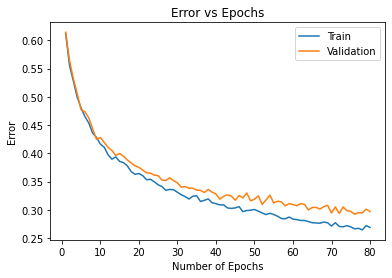

In [11]:
epochList = [i for i in range(1, 81)]
plt.plot(epochList, [1-x for x in trainingAccuracyList], label = "Train")
plt.plot(epochList, [1-y for y in testingAccuracyList], label = "Validation")

plt.xlabel('Number of Epochs') 
plt.ylabel('Error')  
plt.title('Error vs Epochs') 
plt.legend()  
plt.show() 

In [ ]:
#save the model
#torch.save(cnn.state_dict(), 'drive/My Drive/CSCI677-Homeworks/baseline_model.h5')

In [10]:
#Load the Model
Net = torch.load('drive/My Drive/CSCI677-Homeworks/baseline_model.h5')

In [12]:
from sklearn.metrics import confusion_matrix

nb_classes = 10

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long)
lbllist=torch.zeros(0,dtype=torch.long)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testImages):
        outputs = cnn(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1)])
        lbllist=torch.cat([lbllist,classes.view(-1)])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[687  23  51  26  24   5  11  21  74  51]
 [ 17 801   6   8   4   7   7   6  28  95]
 [ 72   1 606  58  95  47  81  36  24  10]
 [ 26   6  77 515  68 154 104  45  21   7]
 [ 27   3  55  43 656  20  46  68  12   3]
 [  8   6  77 177  66 569  37  61   8   6]
 [  7   4  43  46  45  18 807   5  11  10]
 [ 12   6  27  46  64  53  15 740   6  25]
 [ 64  26  13  11   6   8   7   3 841  38]
 [ 30  74   7  22   5   9   8  19  35 831]]
[70.60637205 81.81818182 58.83495146 50.34213099 70.31082529 56.0591133
 81.02409639 74.44668008 82.69419862 79.90384615]


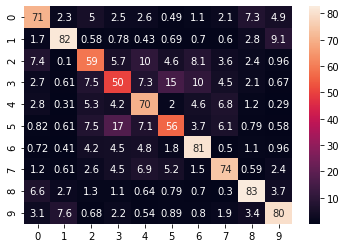

In [13]:
import seaborn as sns
normalized_confMatrix=100*conf_mat/conf_mat.sum(1)
sns.heatmap(normalized_confMatrix, annot=True)